<ipython-input-6-677f08925a83>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_class'] = df['rating'].round().astype(int)


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6343 - loss: 0.6468 - val_accuracy: 0.6237 - val_loss: 0.6397
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6405 - loss: 0.6195 - val_accuracy: 0.6237 - val_loss: 0.6167
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6460 - loss: 0.5969 - val_accuracy: 0.6316 - val_loss: 0.5943
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6698 - loss: 0.5687 - val_accuracy: 0.6474 - val_loss: 0.5716
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6734 - loss: 0.5550 - val_accuracy: 0.6632 - val_loss: 0.5488
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7161 - loss: 0.5302 - val_accuracy: 0.6921 - val_loss: 0.5258
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7350 - loss: 0.5104 - val_accuracy: 0.7395 - val_loss: 0.5042
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7713 - loss: 0.4953 - val_accuracy: 0.7974 - 

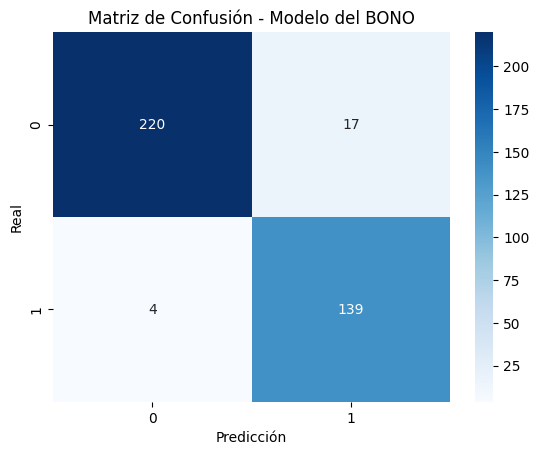

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Mejor vino según el modelo (mayor probabilidad de ser clase 5):

winery: Vega Sicilia
year: 2013.0
rating: 4.8
num_reviews: 172
price: 570.51
body: 5.0
acidity: 3.0
country: Espana
region: Ribera del Duero
type: Ribera Del Duero Red

 Probabilidad predicha de ser clase 5: 0.9862


In [6]:
# Modelo optimizado para el BONO - Mayor F1-score usando la menor cantidad de neuronas

# 1. Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 2. Cargar datos
df = pd.read_csv("wines_SPA.csv")  # Reemplaza si cargas desde Colab o archivos

# 3. Filtrar clases 4 y 5
df = df[df['rating'].round().isin([4, 5])]

# 4. Limpieza y tratamiento de nulos
df = df.drop(columns=['wine'])
num_cols = ['year', 'price', 'num_reviews', 'body', 'acidity']
df[num_cols] = df[num_cols].replace("N.V.", pd.NA)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols + ['rating'])

# 5. Rebalanceo optimizado
df['rating_class'] = df['rating'].round().astype(int)
df_5 = df[df['rating_class'] == 5]
df_5 = pd.concat([df_5] * 4, ignore_index=True)
df_4 = df[df['rating_class'] == 4].sample(n=len(df_5), random_state=42)
df = pd.concat([df_4, df_5], ignore_index=True)

# 6. Outliers
def eliminar_outliers_iqr(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df = eliminar_outliers_iqr(df, ['price', 'num_reviews', 'body', 'acidity'])

df_original = df.copy()  # Guardamos el dataframe antes de codificar

# 7. Transformación y normalización
df = pd.get_dummies(df, columns=['winery', 'country', 'region', 'type'], drop_first=True)
df[num_cols] = df[num_cols].astype('float64')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 8. Dataset
X = df.drop(columns=['rating', 'rating_class'])
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train - 4, num_classes=2)
y_test_cat = to_categorical(y_test - 4, num_classes=2)

# 9. Modelo optimizado: 1 capa oculta con solo 2 neuronas y activación sigmoide
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(2, activation='sigmoid'),
    Dense(2, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 10. Entrenamiento
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

# 11. Evaluación
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) + 4
y_true_labels = np.argmax(y_test_cat, axis=1) + 4

print("== Resultados del Modelo para el Bono ==")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo del BONO")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MEJOR VINO SEGÚN EL MODELO ===

# Predecir sobre todo el dataset
y_all_pred = model.predict(X)
probs_clase_5 = y_all_pred[:, 1]

# Encontrar el índice del vino con mayor probabilidad de ser clase 5
indice_mejor_vino = np.argmax(probs_clase_5)
mejor_vino = df_original.iloc[indice_mejor_vino]

# Mostrar los atributos legibles
print("\n Mejor vino según el modelo (mayor probabilidad de ser clase 5):\n")
for col, val in mejor_vino[['winery', 'year', 'rating', 'num_reviews', 'price', 'body', 'acidity', 'country', 'region', 'type']].items():
    print(f"{col}: {val}")

print(f"\n Probabilidad predicha de ser clase 5: {probs_clase_5[indice_mejor_vino]:.4f}")